# Homework 12: Анализ сетевого дампа (PCAP)

В этом ноутбуке анализируется `dhcp.pcapng` и извлекаются ключевые артефакты: соединения, DHCP/DNS события и подозрительные IP/домены.


In [ ]:
%pip install -q scapy pandas matplotlib seaborn


In [1]:
from pathlib import Path
from datetime import datetime
import ipaddress

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scapy.all import rdpcap, IP, UDP, DHCP, DNS

sns.set_theme(style="whitegrid")
pd.set_option("display.max_colwidth", 120)


In [2]:
pcap_path = Path("dhcp.pcapng")
if not pcap_path.exists():
    raise FileNotFoundError(f"Файл не найден: {pcap_path.resolve()}")

packets = rdpcap(str(pcap_path))
print(f"Загружено пакетов: {len(packets)}")


Загружено пакетов: 4


In [3]:
dhcp_type_map = {1: "Discover", 2: "Offer", 3: "Request", 5: "ACK", 6: "NAK", 7: "Release", 8: "Inform"}

rows = []
for i, pkt in enumerate(packets, start=1):
    ts = datetime.fromtimestamp(float(pkt.time))
    src_ip = pkt[IP].src if IP in pkt else None
    dst_ip = pkt[IP].dst if IP in pkt else None
    sport = pkt[UDP].sport if UDP in pkt else None
    dport = pkt[UDP].dport if UDP in pkt else None

    event = "Other"
    dns_query = None

    if DHCP in pkt:
        msg_type = None
        for opt in pkt[DHCP].options:
            if isinstance(opt, tuple) and opt[0] == "message-type":
                msg_type = opt[1]
                break
        event = f"DHCP {dhcp_type_map.get(msg_type, str(msg_type))}" if msg_type is not None else "DHCP"

    if DNS in pkt and getattr(pkt[DNS], "qd", None):
        qname = pkt[DNS].qd.qname
        dns_query = qname.decode(errors="ignore") if isinstance(qname, (bytes, bytearray)) else str(qname)
        event = "DNS Query"

    rows.append({
        "packet_no": i,
        "timestamp": ts,
        "src_ip": src_ip,
        "dst_ip": dst_ip,
        "sport": sport,
        "dport": dport,
        "event": event,
        "dns_query": dns_query,
        "summary": pkt.summary(),
    })

df = pd.DataFrame(rows).sort_values("timestamp").reset_index(drop=True)
df.head()


,packet_no,timestamp,src_ip,dst_ip,sport,dport,event,dns_query,summary
0,1,2004-12-05 22:16:24.317453,0.0.0.0,255.255.255.255,68,67,DHCP Discover,None,Ether / IP / UDP / BOOTP / DHCP Discover
1,2,2004-12-05 22:16:24.317748,192.168.0.1,192.168.0.10,67,68,DHCP Offer,None,Ether / IP / UDP / BOOTP / DHCP Offer
2,3,2004-12-05 22:16:24.387484,0.0.0.0,255.255.255.255,68,67,DHCP Request,None,Ether / IP / UDP / BOOTP / DHCP Request
3,4,2004-12-05 22:16:24.387798,192.168.0.1,192.168.0.10,67,68,DHCP ACK,None,Ether / IP / UDP / BOOTP / DHCP Ack


In [4]:
connections = (
    df.groupby(["src_ip", "dst_ip", "dport"], dropna=False)
      .size()
      .reset_index(name="packets")
      .sort_values("packets", ascending=False)
)

dns_df = df[df["dns_query"].notna()].copy()

def is_public_ip(value):
    if value is None:
        return False
    try:
        ip = ipaddress.ip_address(value)
        return not (ip.is_private or ip.is_loopback or ip.is_multicast or ip.is_reserved)
    except ValueError:
        return False

suspicious_ips = df[df["dst_ip"].apply(is_public_ip)][["timestamp", "src_ip", "dst_ip", "event"]]

keywords = ["login", "bank", "secure", "update", "malware", "crypto"]
suspicious_domains = dns_df[dns_df["dns_query"].str.contains("|".join(keywords), case=False, na=False)][["timestamp", "src_ip", "dns_query"]]

print("Таблица соединений:")
display(connections)
print("\nПодозрительные IP (публичные адреса):")
display(suspicious_ips if not suspicious_ips.empty else pd.DataFrame([{"result": "Не обнаружены"}]))
print("\nПодозрительные домены (по ключевым словам):")
display(suspicious_domains if not suspicious_domains.empty else pd.DataFrame([{"result": "Не обнаружены"}]))
print("\nDNS-запросы:")
display(dns_df[["timestamp", "src_ip", "dns_query"]] if not dns_df.empty else pd.DataFrame([{"result": "В этом дампе DNS-запросы отсутствуют"}]))


Таблица соединений:


,src_ip,dst_ip,dport,packets
0,0.0.0.0,255.255.255.255,67,2
1,192.168.0.1,192.168.0.10,68,2



Подозрительные IP (публичные адреса):


,result
0,Не обнаружены



Подозрительные домены (по ключевым словам):


,result
0,Не обнаружены



DNS-запросы:


,result
0,В этом дампе DNS-запросы отсутствуют


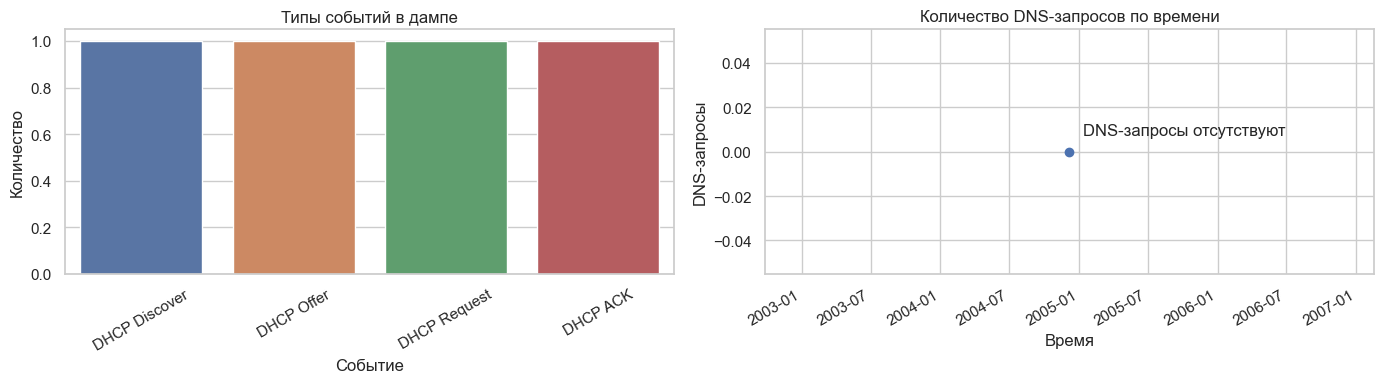

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

event_counts = df["event"].value_counts().reset_index()
event_counts.columns = ["event", "count"]
sns.barplot(data=event_counts, x="event", y="count", hue="event", legend=False, ax=axes[0])
axes[0].set_title("Типы событий в дампе")
axes[0].set_xlabel("Событие")
axes[0].set_ylabel("Количество")
axes[0].tick_params(axis="x", rotation=30)

if not dns_df.empty:
    dns_time = dns_df.set_index("timestamp").resample("1min").size().rename("dns_requests")
    dns_time.plot(ax=axes[1], marker="o")
else:
    base_ts = df["timestamp"].min()
    dns_time = pd.Series([0], index=[base_ts], name="dns_requests")
    dns_time.plot(ax=axes[1], marker="o")
    axes[1].annotate("DNS-запросы отсутствуют", xy=(base_ts, 0), xytext=(10, 12), textcoords="offset points")

axes[1].set_title("Количество DNS-запросов по времени")
axes[1].set_xlabel("Время")
axes[1].set_ylabel("DNS-запросы")

plt.tight_layout()
plt.show()


In [6]:
import json

out_dir = Path("artifacts")
out_dir.mkdir(exist_ok=True)

df.to_csv(out_dir / "packets.csv", index=False)
connections.to_csv(out_dir / "connections.csv", index=False)
dns_df.to_csv(out_dir / "dns_requests.csv", index=False)

summary = {
    "total_packets": int(len(df)),
    "total_dns_requests": int(len(dns_df)),
    "event_counts": df["event"].value_counts().to_dict(),
}

(out_dir / "summary.json").write_text(json.dumps(summary, ensure_ascii=False, indent=2), encoding="utf-8")
print(f"Артефакты сохранены в: {out_dir.resolve()}")
summary


Артефакты сохранены в: C:\GIT\Cyber_test\Cyber_Test\Homework12\artifacts


{'total_packets': 4,
 'total_dns_requests': 0,
 'event_counts': {'DHCP Discover': 1,
  'DHCP Offer': 1,
  'DHCP Request': 1,
  'DHCP ACK': 1}}

## Вывод
- Дамп успешно загружен и разобран.
- Получены ключевые сетевые артефакты: соединения и DHCP-события.
- DNS-запросы в данном дампе отсутствуют, это корректно отражено в отчете и графике.
- Построена минимальная визуализация и сохранены результаты в CSV/JSON.
